# Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('simulation_results.csv')
adj = pd.read_csv('adj_matrix.csv', header=None).drop(0, axis=0).reset_index(drop=True)
adj = np.array(adj).astype(int)

ADJ = pd.DataFrame(adj)
# rename columns and rows
ADJ.columns = [f'X{i}' for i in range(1, 10)]
ADJ.index = [f'X{i}' for i in range(1, 10)]

# save as latex
ADJ.to_latex('ADJ.tex')

data1 = data[data['Simulation_ID'] == 100]
# pivot the data by Observation_ID
data1 = data1.pivot(index='Observation_ID', columns='Node_ID', values=['Treatment', 'Outcome'])


sim = pd.DataFrame()
for i in range(1, 10):
    sim['treatment_' + str(i)] = data1['Treatment'][i]
    sim['outcome_' + str(i)] = data1['Outcome'][i]

sim1 = np.array(sim[['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9']])



# Causal Discovery Algorithm Implementation

## PC

  0%|          | 0/9 [00:00<?, ?it/s]

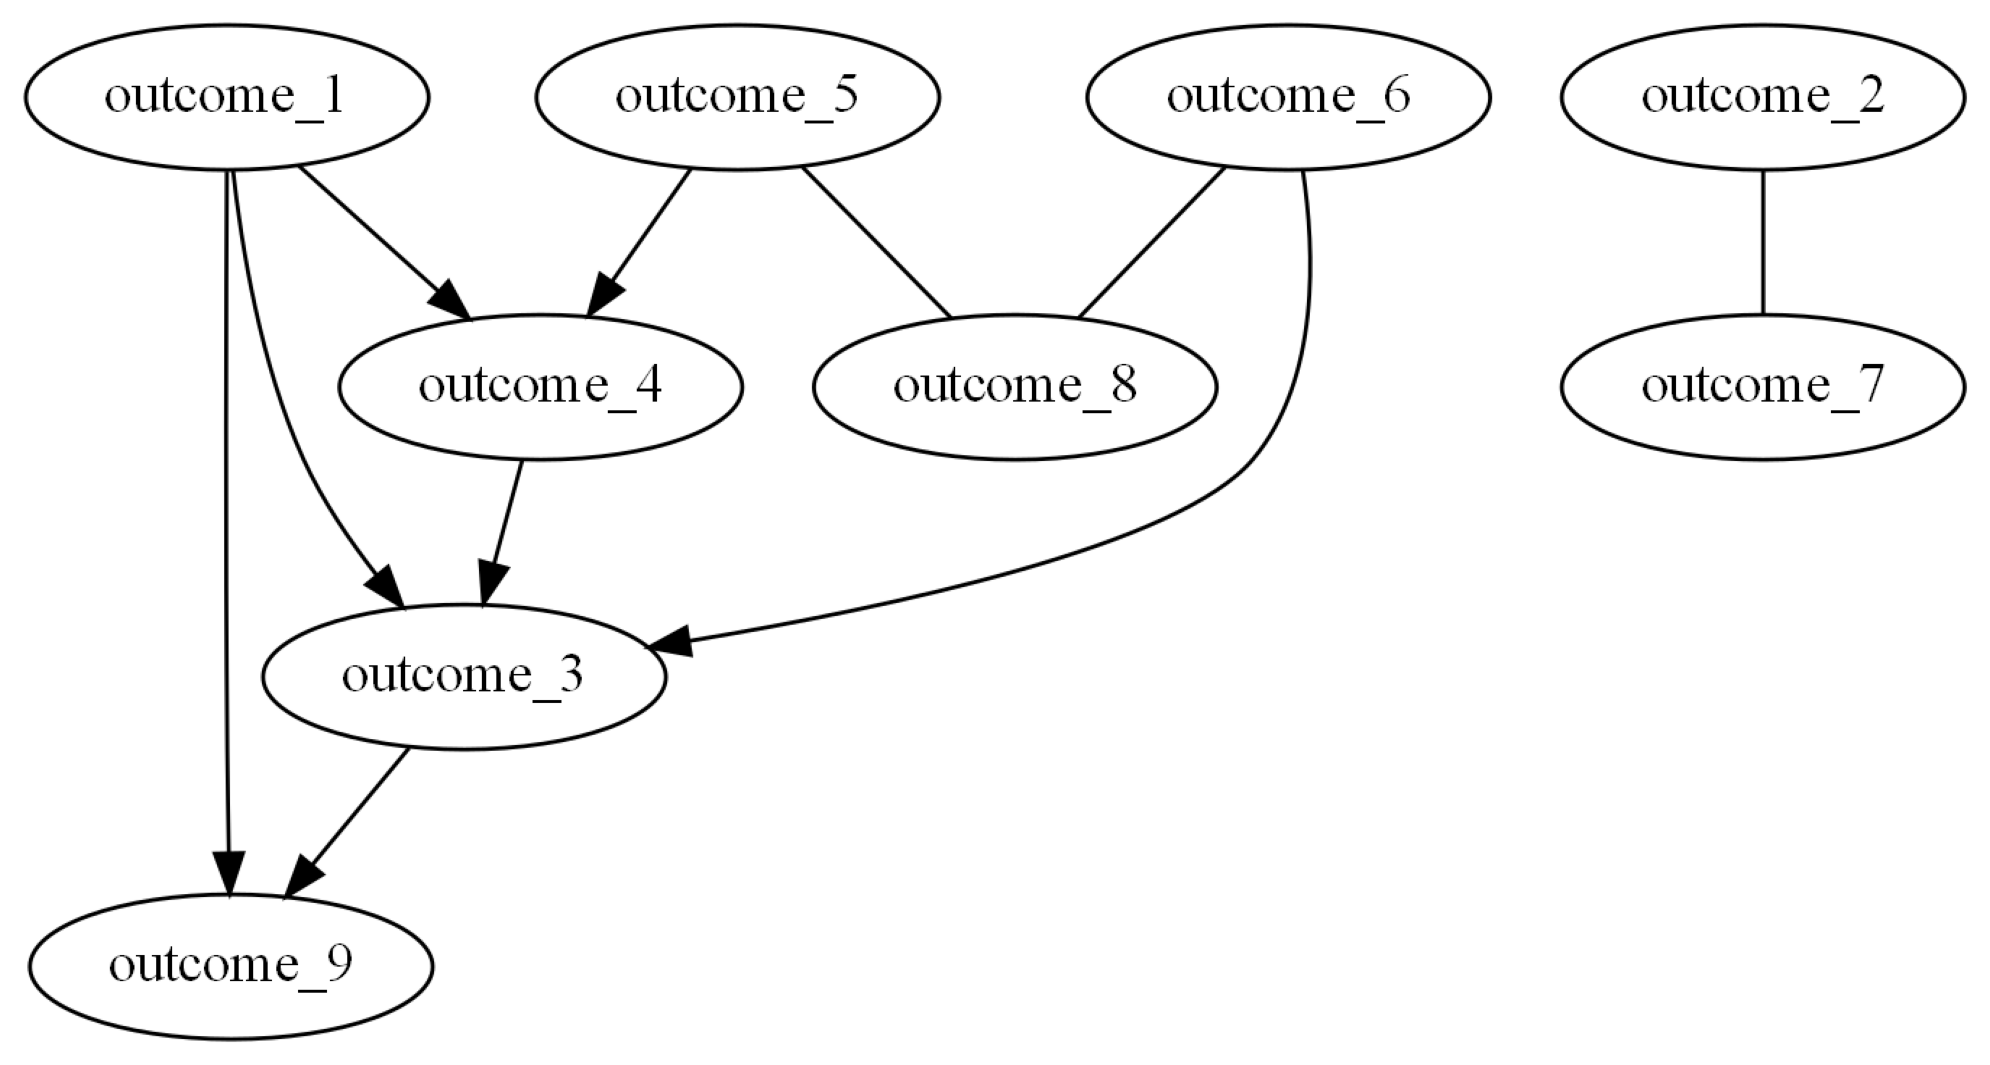

In [5]:
from causallearn.utils.GraphUtils import GraphUtils
import os
import pydot
import bnlearn as bn
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs import CPDAG
from pywhy_graphs.viz import draw
from causallearn.search.ConstraintBased.PC import pc

sim1 = np.array(sim[['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9']])

cg = pc(sim1)

pyd = GraphUtils.to_pydot(cg.G)
pyd.write_png('PC.png')

# visualization using networkx
# cg.to_nx_graph()
cg.draw_pydot_graph(labels = ['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9'])

In [8]:
cg.G.graph

array([[ 0,  0, -1, -1,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 1,  0,  0,  1,  0,  1,  0,  0, -1],
       [ 1,  0, -1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0, -1,  0],
       [ 0,  0, -1,  0,  0,  0,  0, -1,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1, -1,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0,  0]])

In [61]:
adj == cg.G.graph

array([[ True,  True, False, False,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True, False,  True],
       [ True,  True, False,  True,  True,  True,  True, False,  True],
       [ True, False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [62]:
# misclassified rate
np.sum(adj != cg.G.graph) / (adj.shape[0] * adj.shape[1])

0.16049382716049382

## FCI

In [113]:
from causallearn.search.ConstraintBased.FCI import fci

# default parameters
cg = fci(sim1)

# visualization
from causallearn.utils.GraphUtils import GraphUtils

pdy = GraphUtils.to_pydot(cg[0],labels=['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9'])
pdy.write_png('FCI.png')
# GraphUtils.draw_pydot_graph(cg[0], labels=['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9'])


  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5


In [115]:
cg

(<causallearn.graph.GeneralGraph.GeneralGraph at 0x159c1b7c9d0>,
  <causallearn.graph.Edge.Edge at 0x159bc809050>])

## GES algo with BIC score

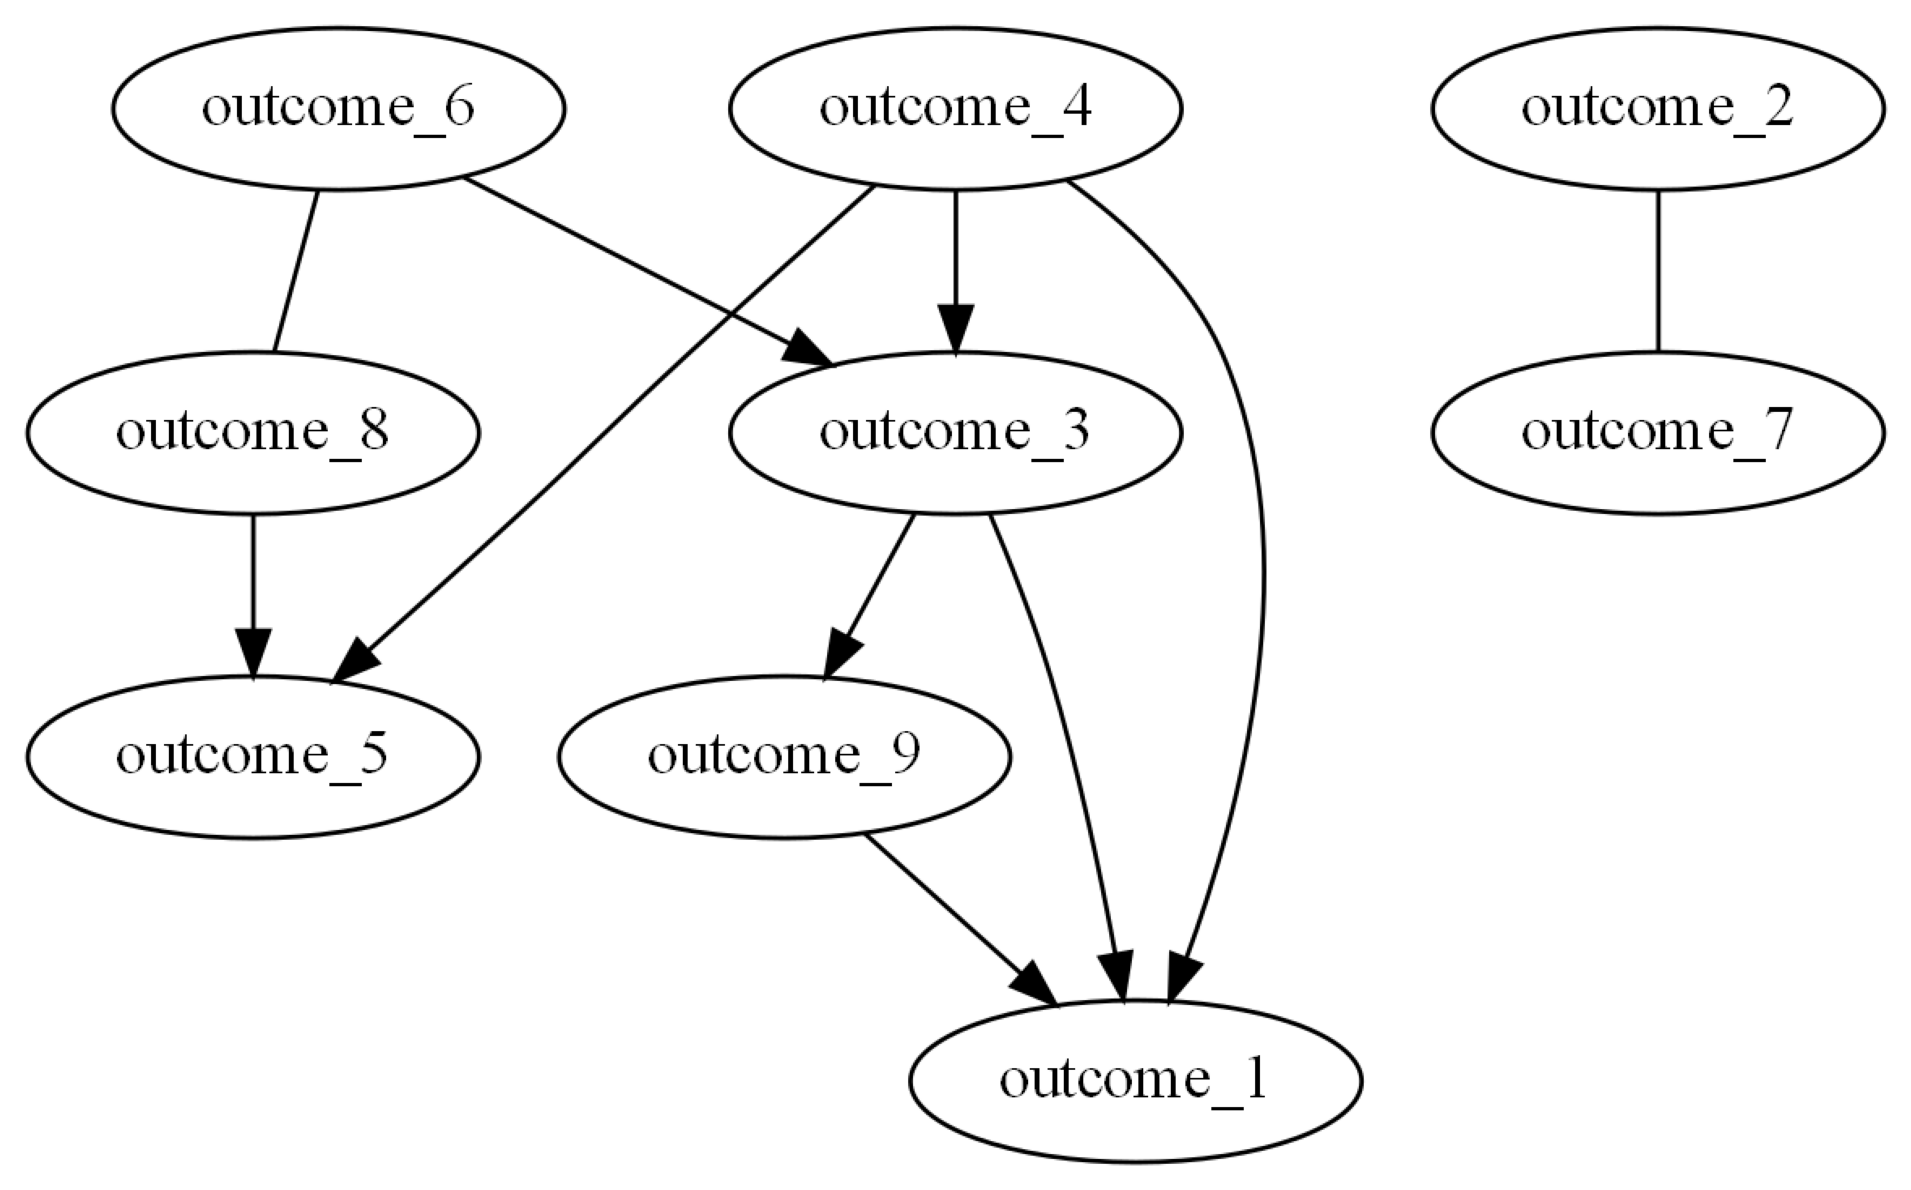

In [49]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(sim1)


# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'],labels=['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()


# or save the graph
pyd.write_png('GES.png')

In [ ]:
Record['G'].graph

## ICA-based LiNGAM

In [35]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(sim1)

print(model.causal_order_)
print(model.adjacency_matrix_)

[1, 2, 0, 3, 4, 5, 6, 7, 8]
[[0.         0.         0.38275257 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.14955605 0.         0.24438213 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.281783   0.         0.
  0.         0.         0.        ]
 [0.         0.         0.2160604  0.         0.         0.
  0.         0.         0.        ]
 [0.         0.22228411 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.22629152 0.2448064
  0.         0.         0.        ]
 [0.30418177 0.         0.16545899 0.         0.         0.
  0.         0.         0.        ]]


## GIN

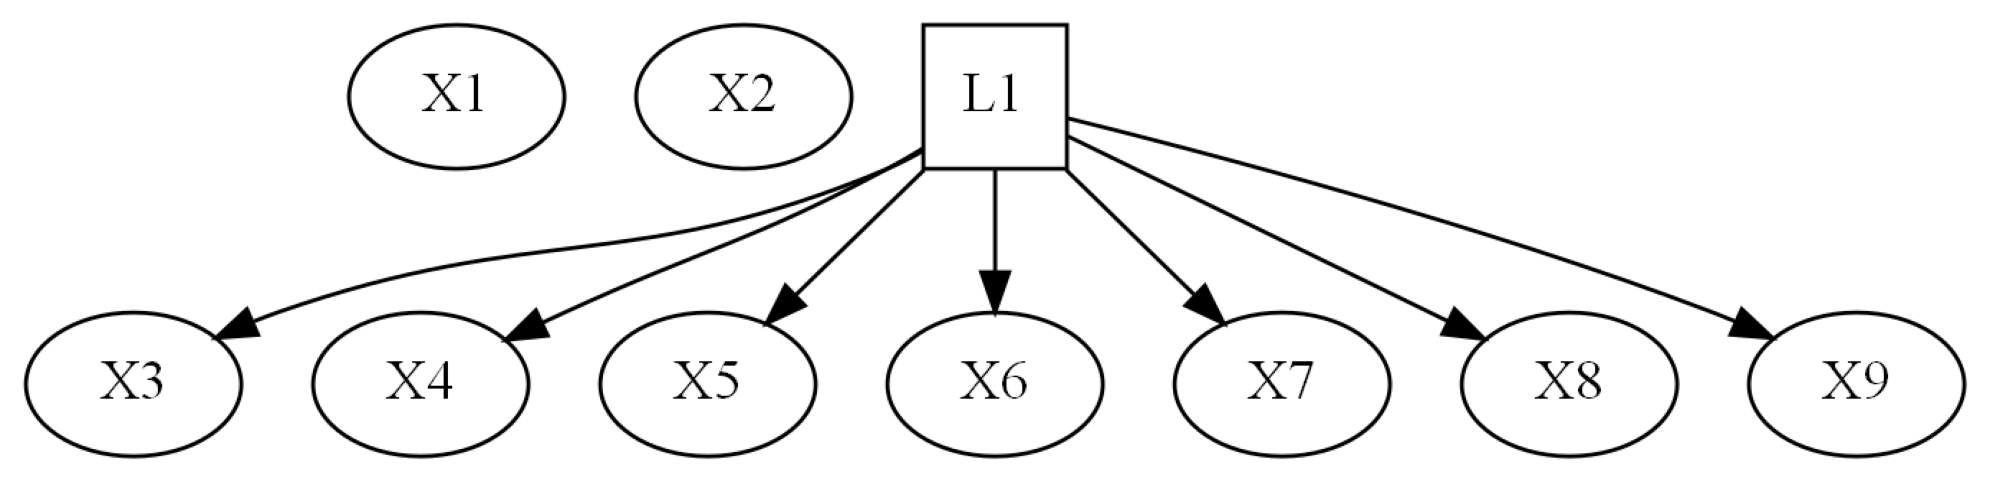

In [50]:
from causallearn.search.HiddenCausal.GIN.GIN import GIN
G, K = GIN(sim1)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(G)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

## GRaSP

GRaSP edge count: 10    
GRaSP completed in: 0.22s 


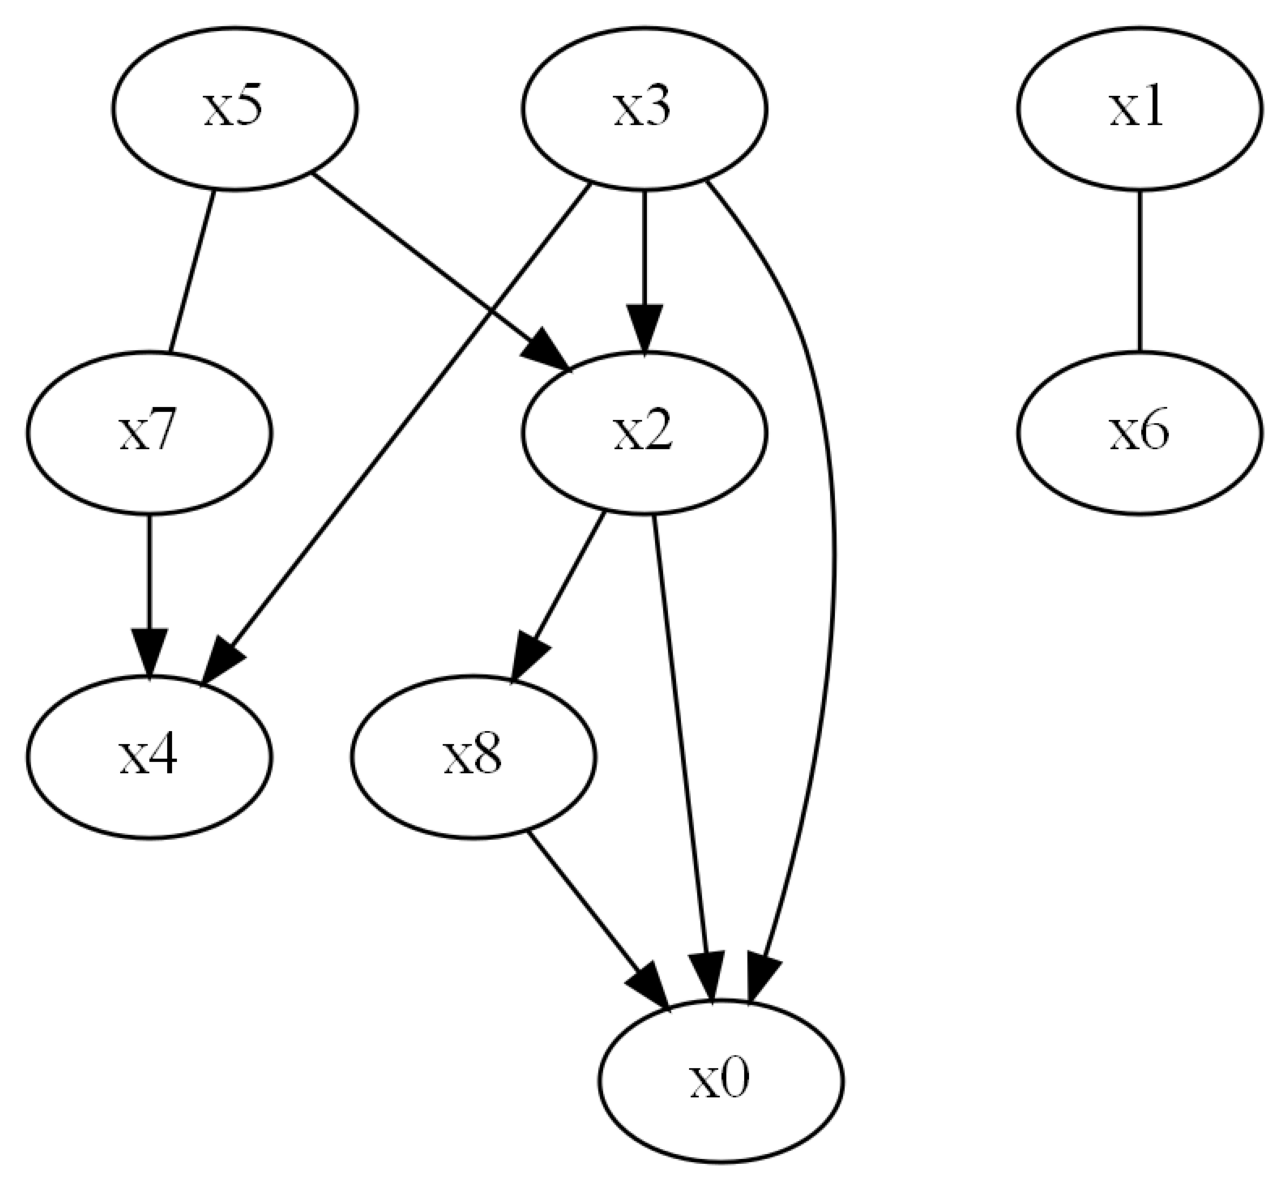

In [38]:
from causallearn.search.PermutationBased.GRaSP import grasp

# default parameters
G = grasp(sim1)


# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(G)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# Misclassification rate

In [116]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.FCMBased import lingam
from causallearn.search.PermutationBased.GRaSP import grasp

pc_result = []
fci_result = []
ges_result = []
GRaSP_result = []
for i in data['Simulation_ID'].unique():
    data1 = data[data['Simulation_ID'] == i]
    # pivot the data by Observation_ID
    data1 = data1.pivot(index='Observation_ID', columns='Node_ID', values=['Treatment', 'Outcome'])
    sim = pd.DataFrame()
    for k in range(1, 10):
        sim['treatment_' + str(k)] = data1['Treatment'][k]
        sim['outcome_' + str(k)] = data1['Outcome'][k]
    sim1 = np.array(sim[['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9']])

    # PC
    cg = pc(sim1)
    pc_result.append(np.sum(adj != cg.G.graph) / (adj.shape[0] * adj.shape[1]))

    # FCI 
    cg = fci(sim1)
    fci_result.append(np.sum(adj != cg[0].graph) / (adj.shape[0] * adj.shape[1]))

    # GES
    Record = ges(sim1)
    ges_result.append(np.sum(adj != Record['G'].graph) / (adj.shape[0] * adj.shape[1]))

    # GRaSP
    G = grasp(sim1)
    GRaSP_result.append(np.sum(adj != G.graph) / (adj.shape[0] * adj.shape[1]))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9

GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X5 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
X9 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X5 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X6 --> X3
X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.03s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9

GRaSP completed in: 0.03s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X5 --> X8
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4

GRaSP completed in: 0.03s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X8 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X8 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.03s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X6 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X9 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X5 --> X8

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X3
X3 --> X4
X3 --> X6
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.16s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X8 --> X6
X9 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X8 --> X6

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X3
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X3 --> X6
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X8 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 9    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X9 --> X3
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
X6 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X8 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X6 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.16s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X3 --> X5
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X6 --> X3
X3 --> X9
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9

GRaSP completed in: 0.03s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.20s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X9 --> X1
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X5 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X9 --> X3
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X4 --> X3
X3 --> X6
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X8
X8 --> X6
GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
GRaSP edge count: 11    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 11    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X6
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.20s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.16s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X5 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X6
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X9 --> X1
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
X6 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X6 --> X3
X5 --> X8
X8 --> X6

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X8 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.15s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X9 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X9 --> X1
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
X4 --> X5

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X3 --> X9
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1

GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X3 --> X4
X3 --> X9
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
X4 --> X3
X3 --> X6
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X3
X4 --> X1
X1 --> X9
X9 --> X2
X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X3 --> X6
X5 --> X4
X8 --> X5
X6 --> X8

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X4 --> X3
X3 --> X6
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X9 --> X3
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X6

GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9

GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X6 --> X3
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
X5 --> X4
X8 --> X5
X6 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.09s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X4 --> X3
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X4 --> X3
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X3
X3 --> X6
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X4 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X4
X3 --> X4
X4 --> X5
X5 --> X8
X8 --> X6
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X1 --> X9
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X1
X4 --> X1
X3 --> X9
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
X4 --> X5
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X3 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.07s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


GRaSP completed in: 0.08s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X4
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

GRaSP edge count: 10    
GRaSP completed in: 0.05s 


## Mean Square Error

In [6]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.FCMBased import lingam
from causallearn.search.PermutationBased.GRaSP import grasp

lingam_results = []
for i in data['Simulation_ID'].unique():
    data1 = data[data['Simulation_ID'] == i]
    # pivot the data by Observation_ID
    data1 = data1.pivot(index='Observation_ID', columns='Node_ID', values=['Treatment', 'Outcome'])
    sim = pd.DataFrame()
    for k in range(1, 10):
        sim['treatment_' + str(k)] = data1['Treatment'][k]
        sim['outcome_' + str(k)] = data1['Outcome'][k]
    sim1 = np.array(sim[['outcome_1', 'outcome_2', 'outcome_3', 'outcome_4', 'outcome_5', 'outcome_6', 'outcome_7', 'outcome_8', 'outcome_9']])

    # LiNGAM
    model = lingam.ICALiNGAM()
    model.fit(sim1)
    # mean squared error between the true and estimated adjacency matrix
    diff = np.sum((adj - model.adjacency_matrix_) ** 2) / (adj.shape[0] * adj.shape[1])
    lingam_results.append(diff)

In [119]:
index = ['PC', 'FCI', 'GES', 'LiNGAM', 'GRaSP']
avg = [np.mean(pc_result), np.mean(fci_result), np.mean(ges_result), np.mean(lingam_results), np.mean(GRaSP_result)]
std = [np.std(pc_result), np.std(fci_result), np.std(ges_result), np.std(lingam_results), np.std(GRaSP_result)]
summary_tab = pd.DataFrame({'Average Misclassification Rate': avg, 'Standard Deviation': std}, index=index)
summary_tab.to_csv('summary_tab.csv')
# save as latex
summary_tab.to_latex('summary_tab.tex')
print(summary_tab)

        Average Misclassification Rate  Standard Deviation
PC                            0.171247            0.028012
FCI                           0.140086            0.039407
GES                           0.189210            0.027820
LiNGAM                        0.252802            0.008898
GRaSP                         0.193160            0.027447


# CFL

## Packages

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split

import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout

[setgraphviz] >WARNING> From c:\Users\huang\anaconda3\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



## CFL Framework

In [40]:
def build_network(trial):

    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()

    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

In [41]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

    CDE_params = {
        'model'        : 'CondExpDIY',
        'model_params' : {
            'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
            'optuna_trial'    : trial,
            'build_network'     : build_network,

            'batch_size'      : trial.suggest_int("batch_size", 16, 128),
            'n_epochs'        : 100,
            'optimizer'       : 'adam',
            'opt_config'      : {'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)},
            'loss'            : 'mean_squared_error',
            'best'            : True,
            'verbose'         : 0,
            'early_stopping'  : True,
        }
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X,
                        Y_train=Y,
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

## Training

In [48]:
Y = sim['outcome_7'].values.reshape(-1, 1)
# X = data_adjusted.drop(columns=['treat']).values
X = sim.drop(columns=['outcome_7','treatment_1', 'treatment_2', 'treatment_3', 'treatment_4', 'treatment_5', 'treatment_6', 'treatment_7', 'treatment_8', 'treatment_9']).values

# split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# get the indices of the training and testing data
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

print(X.shape)
print(Y.shape)

(1000, 8)
(1000, 1)


[I 2025-01-05 00:46:17,935] A new study created in memory with name: no-name-3afc7ed9-89d7-400b-92de-bf36c3b90595


Block: verbose not specified in input, defaulting to 1


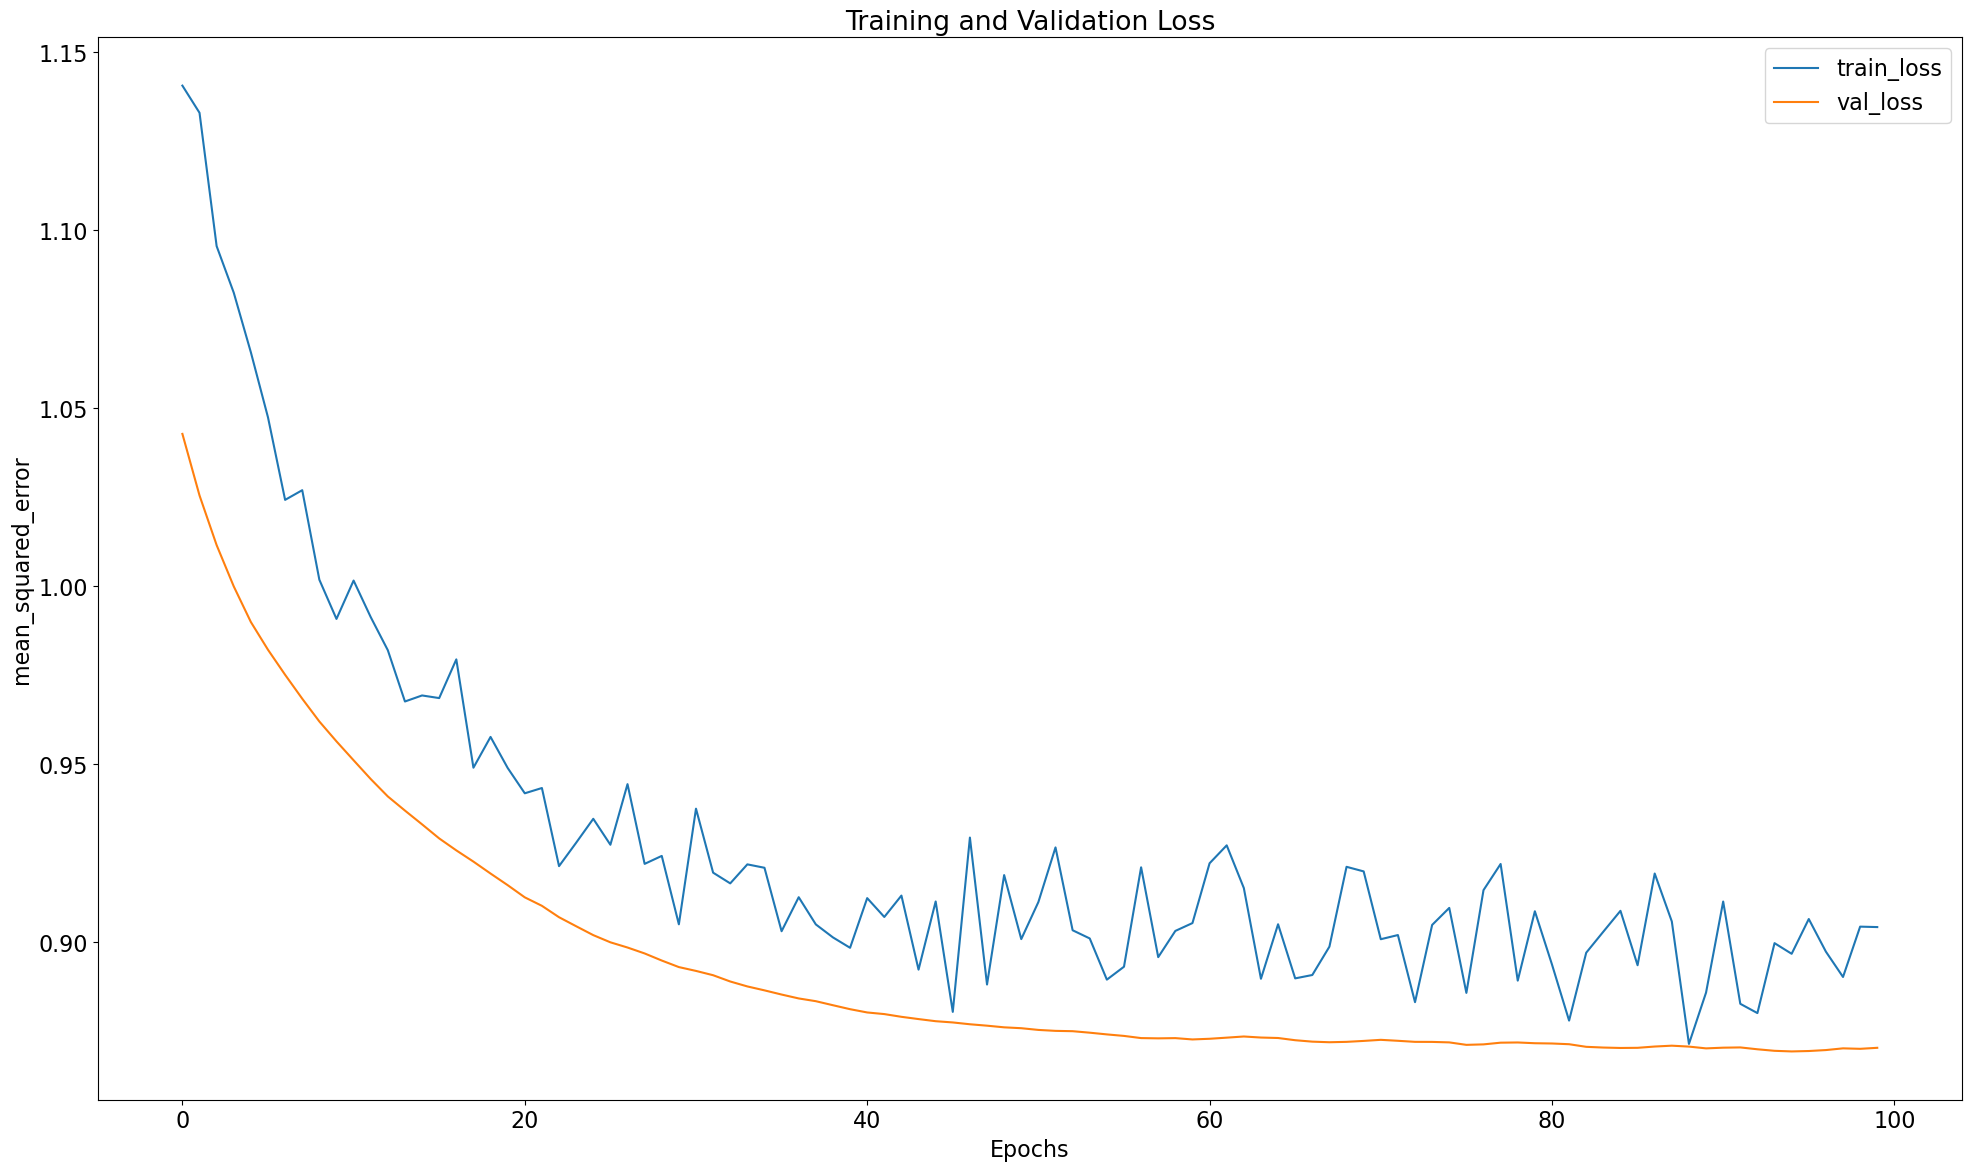

32/32 [==============================] - 0s 2ms/step


[I 2025-01-05 00:46:47,291] Trial 0 finished with value: 0.8703978657722473 and parameters: {'batch_size': 55, 'learning_rate': 1.7150756398737018e-05, 'n_layers': 5, 'n_units_l0': 44, 'dropout_l0': 0.3484385149606519, 'n_units_l1': 26, 'dropout_l1': 0.09131908562244606, 'n_units_l2': 284, 'dropout_l2': 0.02230377547848078, 'n_units_l3': 329, 'dropout_l3': 0.49274947995686397, 'n_units_l4': 26, 'dropout_l4': 0.4497189176513138}. Best is trial 0 with value: 0.8703978657722473.


Block: verbose not specified in input, defaulting to 1


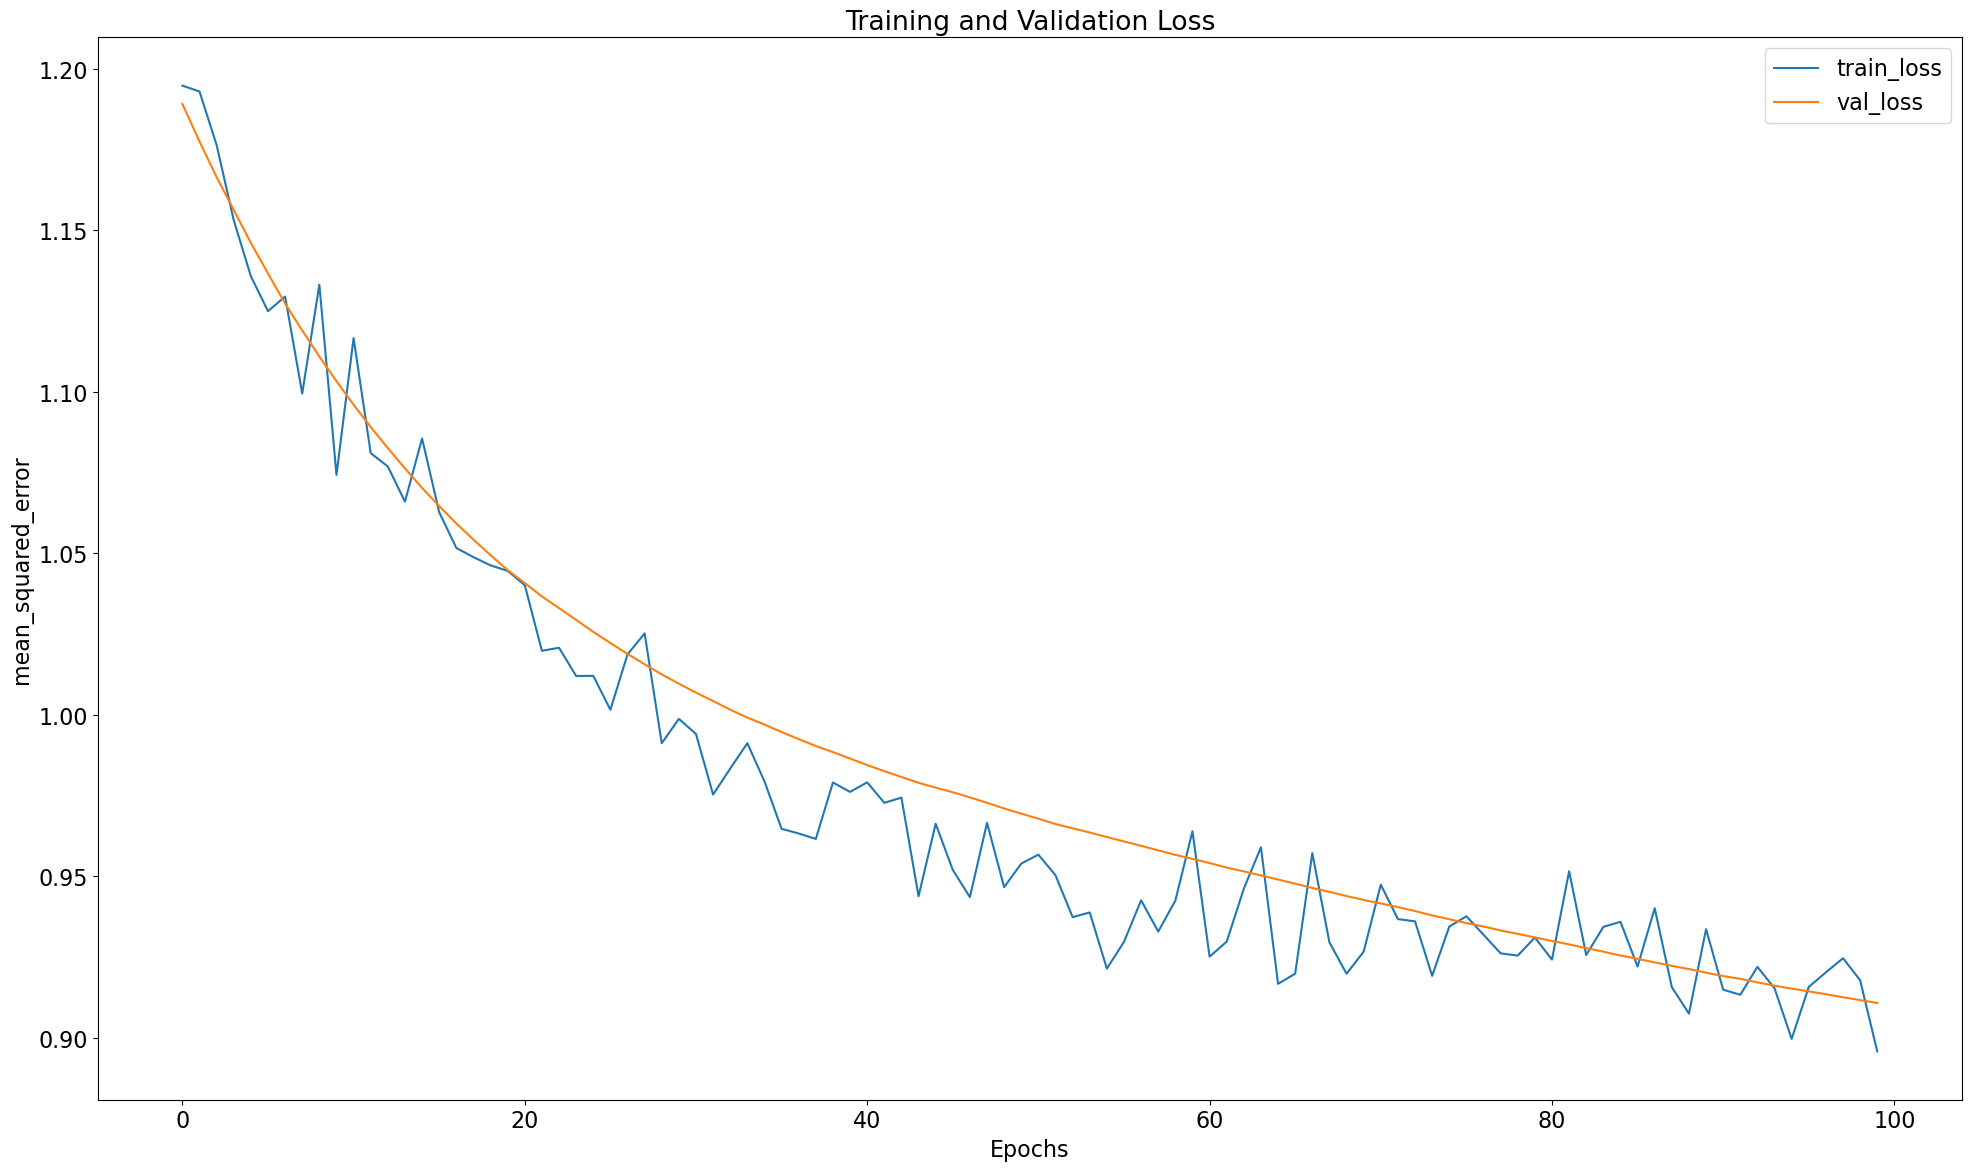

32/32 [==============================] - 0s 2ms/step


[I 2025-01-05 00:47:05,160] Trial 1 finished with value: 0.9108292460441589 and parameters: {'batch_size': 89, 'learning_rate': 1.7060375825383834e-05, 'n_layers': 2, 'n_units_l0': 58, 'dropout_l0': 0.2561854327984255, 'n_units_l1': 155, 'dropout_l1': 0.188524372854373}. Best is trial 0 with value: 0.8703978657722473.


Block: verbose not specified in input, defaulting to 1


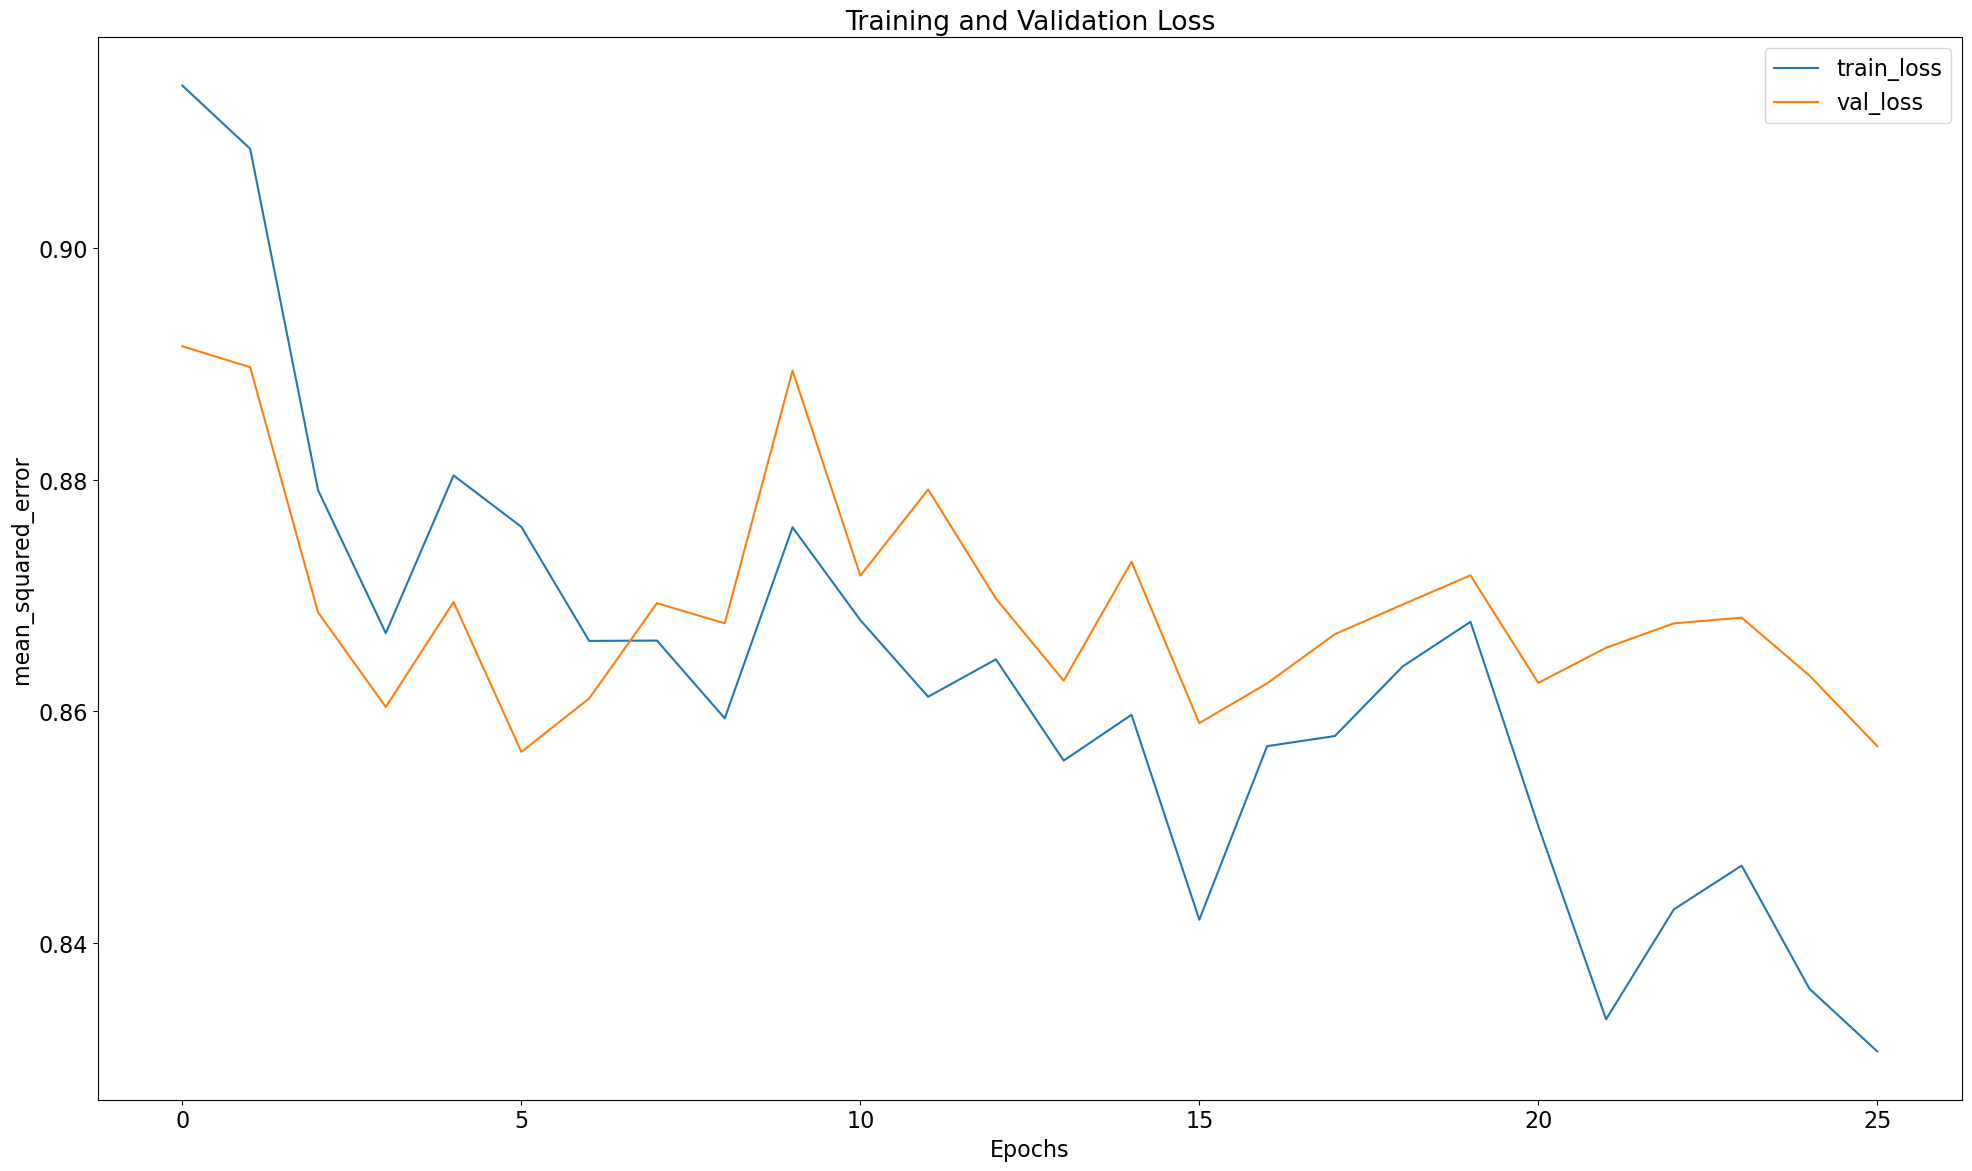

32/32 [==============================] - 0s 2ms/step


[I 2025-01-05 00:47:10,618] Trial 2 finished with value: 0.8570072650909424 and parameters: {'batch_size': 34, 'learning_rate': 0.0007370259481363447, 'n_layers': 5, 'n_units_l0': 79, 'dropout_l0': 0.0768958441191186, 'n_units_l1': 12, 'dropout_l1': 0.4085331298755392, 'n_units_l2': 337, 'dropout_l2': 0.002836494509872889, 'n_units_l3': 18, 'dropout_l3': 0.440397678945604, 'n_units_l4': 391, 'dropout_l4': 0.26318122414168554}. Best is trial 2 with value: 0.8570072650909424.


Block: verbose not specified in input, defaulting to 1


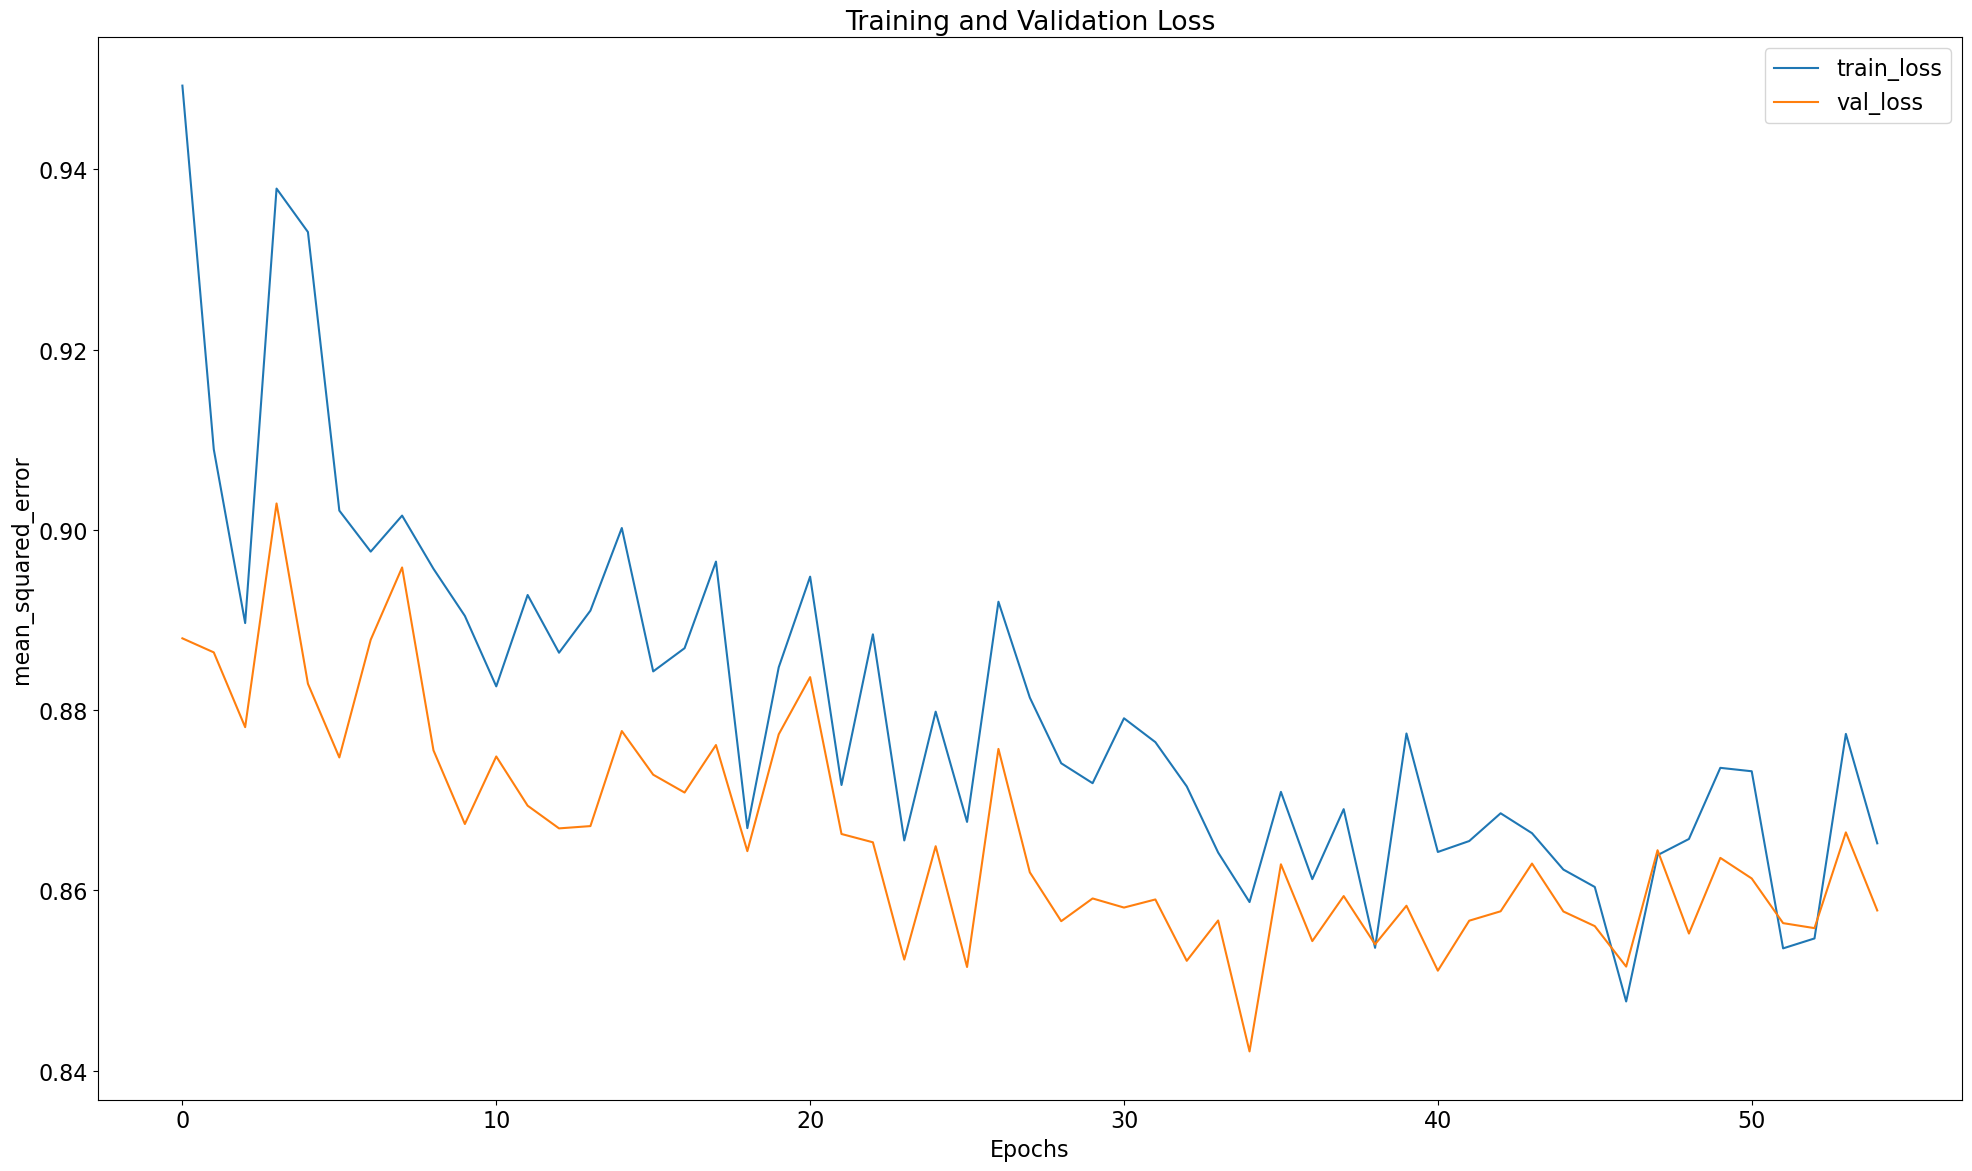

32/32 [==============================] - 0s 2ms/step


[I 2025-01-05 00:47:19,952] Trial 3 finished with value: 0.8577750325202942 and parameters: {'batch_size': 29, 'learning_rate': 0.00046364992820848935, 'n_layers': 5, 'n_units_l0': 7, 'dropout_l0': 0.10728810967624375, 'n_units_l1': 100, 'dropout_l1': 0.4811600616227509, 'n_units_l2': 467, 'dropout_l2': 0.18110850879802942, 'n_units_l3': 75, 'dropout_l3': 0.3380343267440556, 'n_units_l4': 4, 'dropout_l4': 0.1986624182296186}. Best is trial 2 with value: 0.8570072650909424.


Block: verbose not specified in input, defaulting to 1


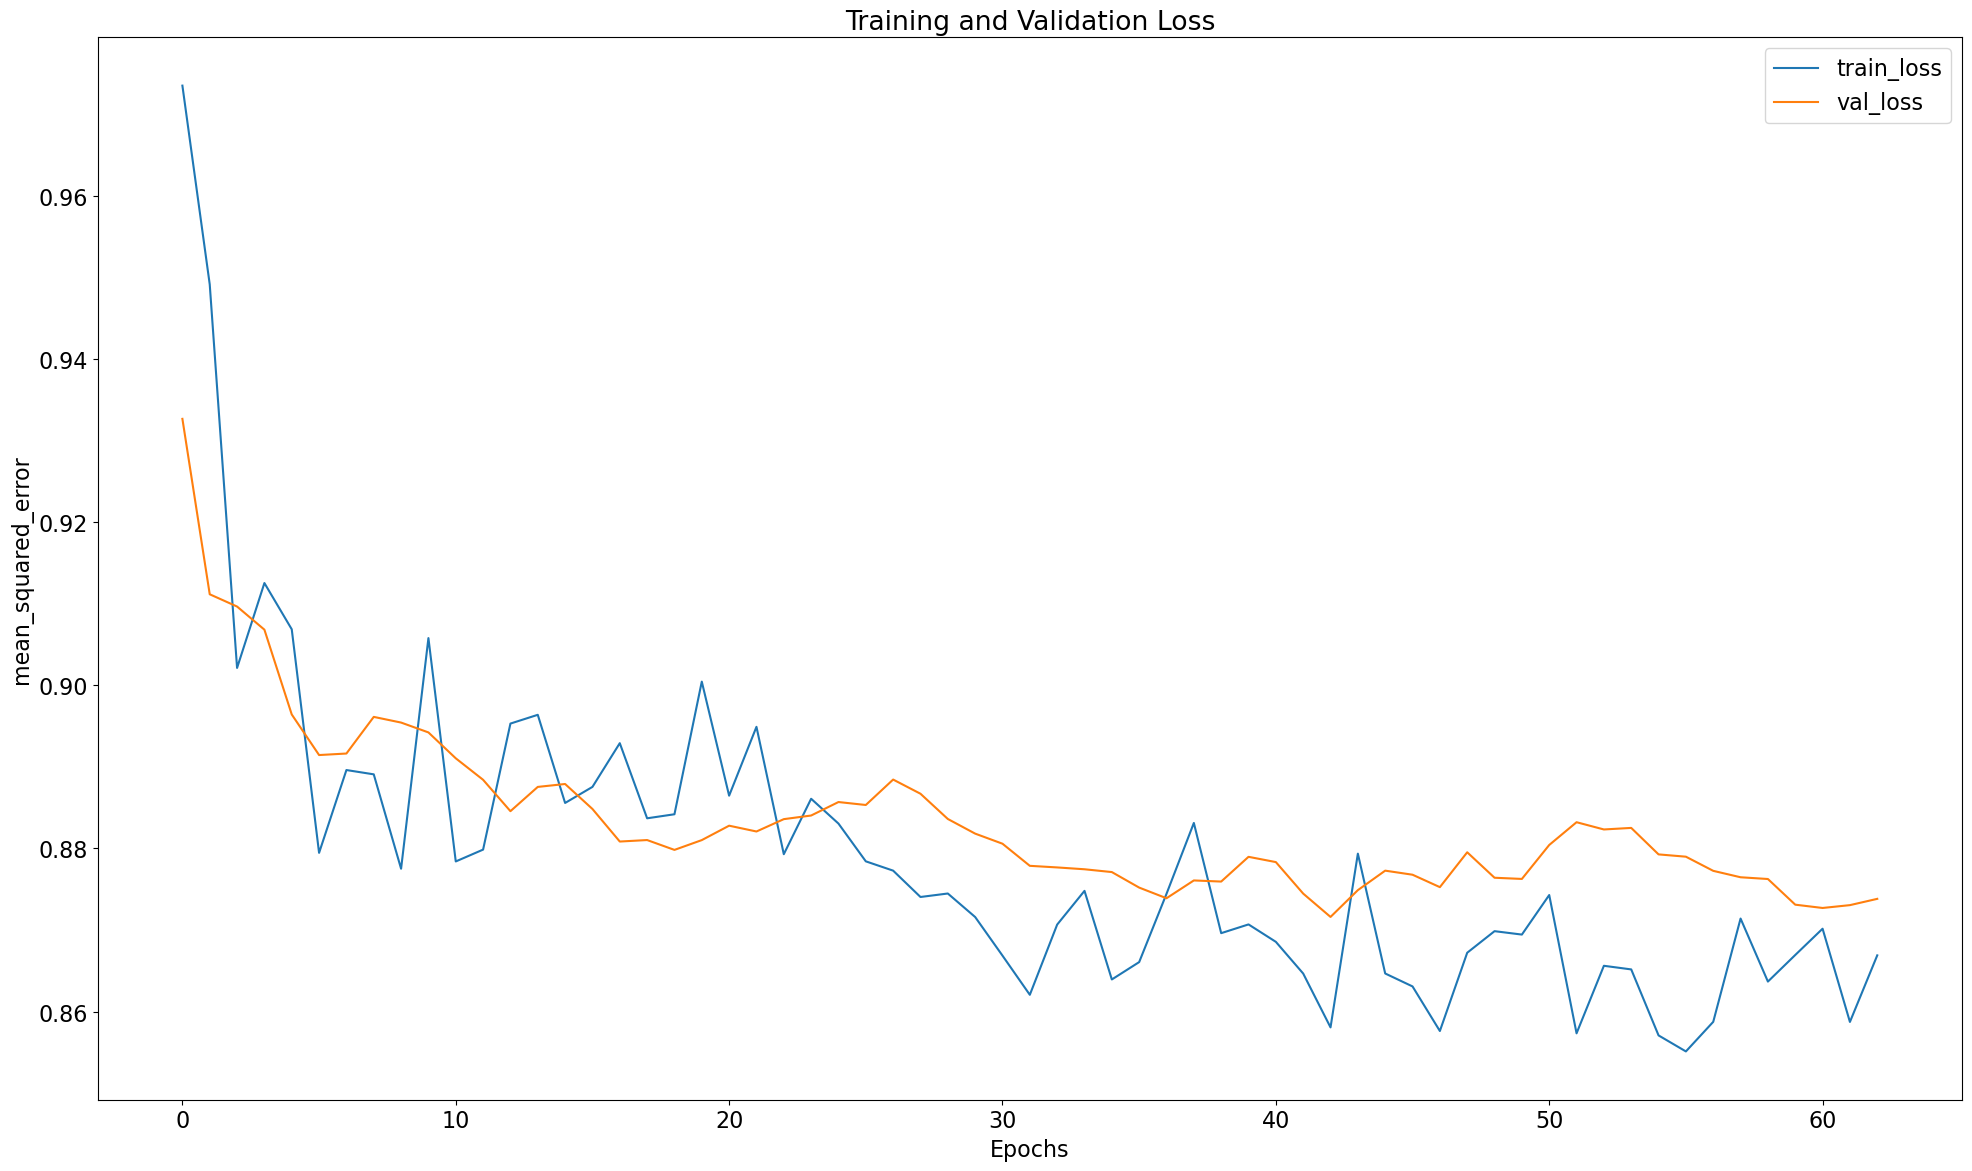

32/32 [==============================] - 0s 1ms/step


[I 2025-01-05 00:47:27,334] Trial 4 finished with value: 0.8738203048706055 and parameters: {'batch_size': 108, 'learning_rate': 0.00077518772680662, 'n_layers': 4, 'n_units_l0': 22, 'dropout_l0': 0.13220806006956615, 'n_units_l1': 13, 'dropout_l1': 0.49934269456751545, 'n_units_l2': 25, 'dropout_l2': 0.22919358753821867, 'n_units_l3': 410, 'dropout_l3': 0.3665827410731461}. Best is trial 2 with value: 0.8570072650909424.


Block: verbose not specified in input, defaulting to 1


[I 2025-01-05 00:47:28,778] Trial 5 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[I 2025-01-05 00:47:29,841] Trial 6 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[I 2025-01-05 00:47:36,668] Trial 7 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[setgraphviz] >WARNING> 5 out of the last 199 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022616504FE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[I 2025-01-05 00:47:37,370] Trial 8 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


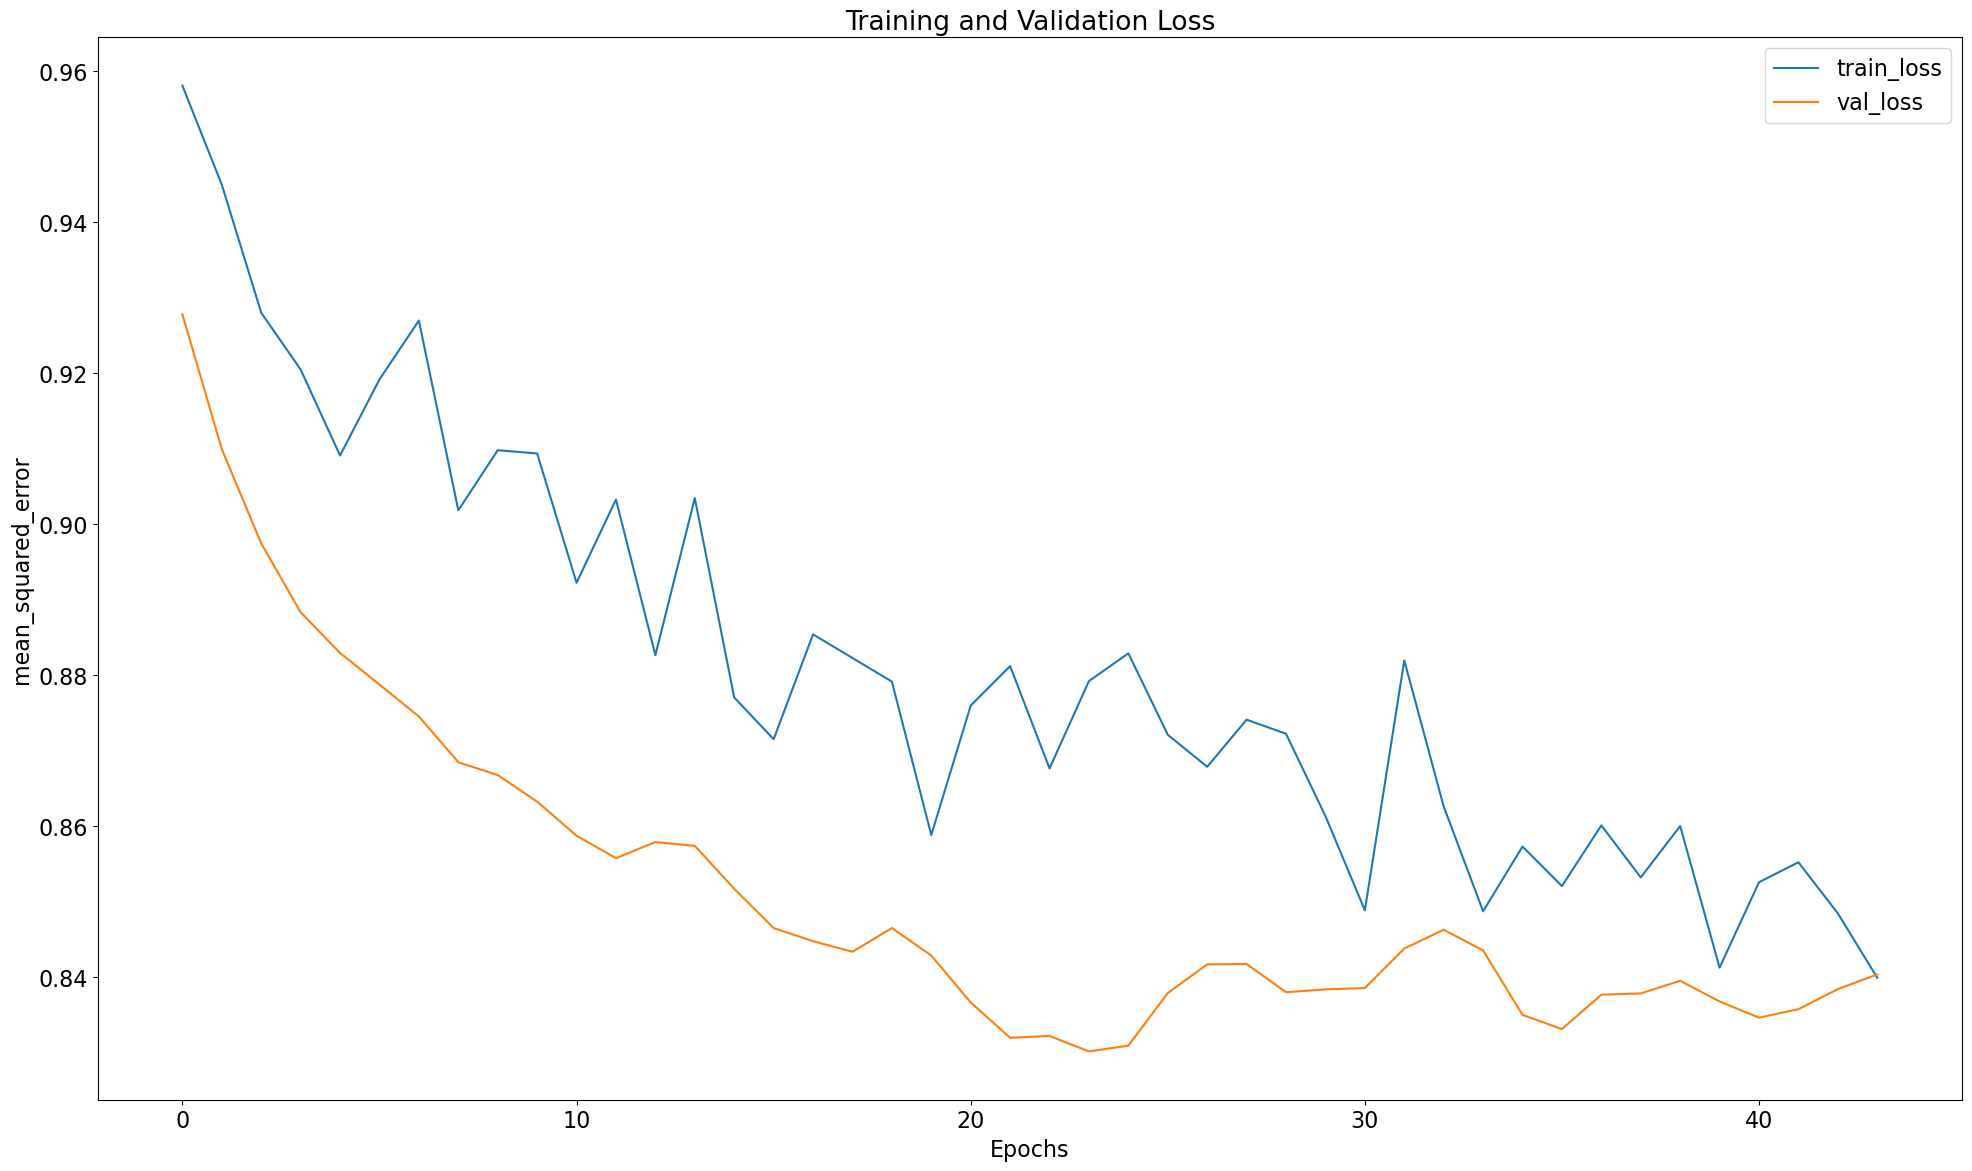

32/32 [==============================] - 0s 2ms/step


[I 2025-01-05 00:47:44,471] Trial 9 finished with value: 0.8403168320655823 and parameters: {'batch_size': 90, 'learning_rate': 0.00015124935842603557, 'n_layers': 5, 'n_units_l0': 70, 'dropout_l0': 0.03246497242374391, 'n_units_l1': 75, 'dropout_l1': 0.003807657257105579, 'n_units_l2': 271, 'dropout_l2': 0.4544536591833133, 'n_units_l3': 222, 'dropout_l3': 0.43709756998076554, 'n_units_l4': 5, 'dropout_l4': 0.15057422169485168}. Best is trial 9 with value: 0.8403168320655823.


In [49]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)

In [50]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8403168320655823
  Params: 
    batch_size: 90
    learning_rate: 0.00015124935842603557
    n_layers: 5
    n_units_l0: 70
    dropout_l0: 0.03246497242374391
    n_units_l1: 75
    dropout_l1: 0.003807657257105579
    n_units_l2: 271
    dropout_l2: 0.4544536591833133
    n_units_l3: 222
    dropout_l3: 0.43709756998076554
    n_units_l4: 5
    dropout_l4: 0.15057422169485168


## Optimal Model and Output

All results from this run will be saved to demo_results\experiment0001
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


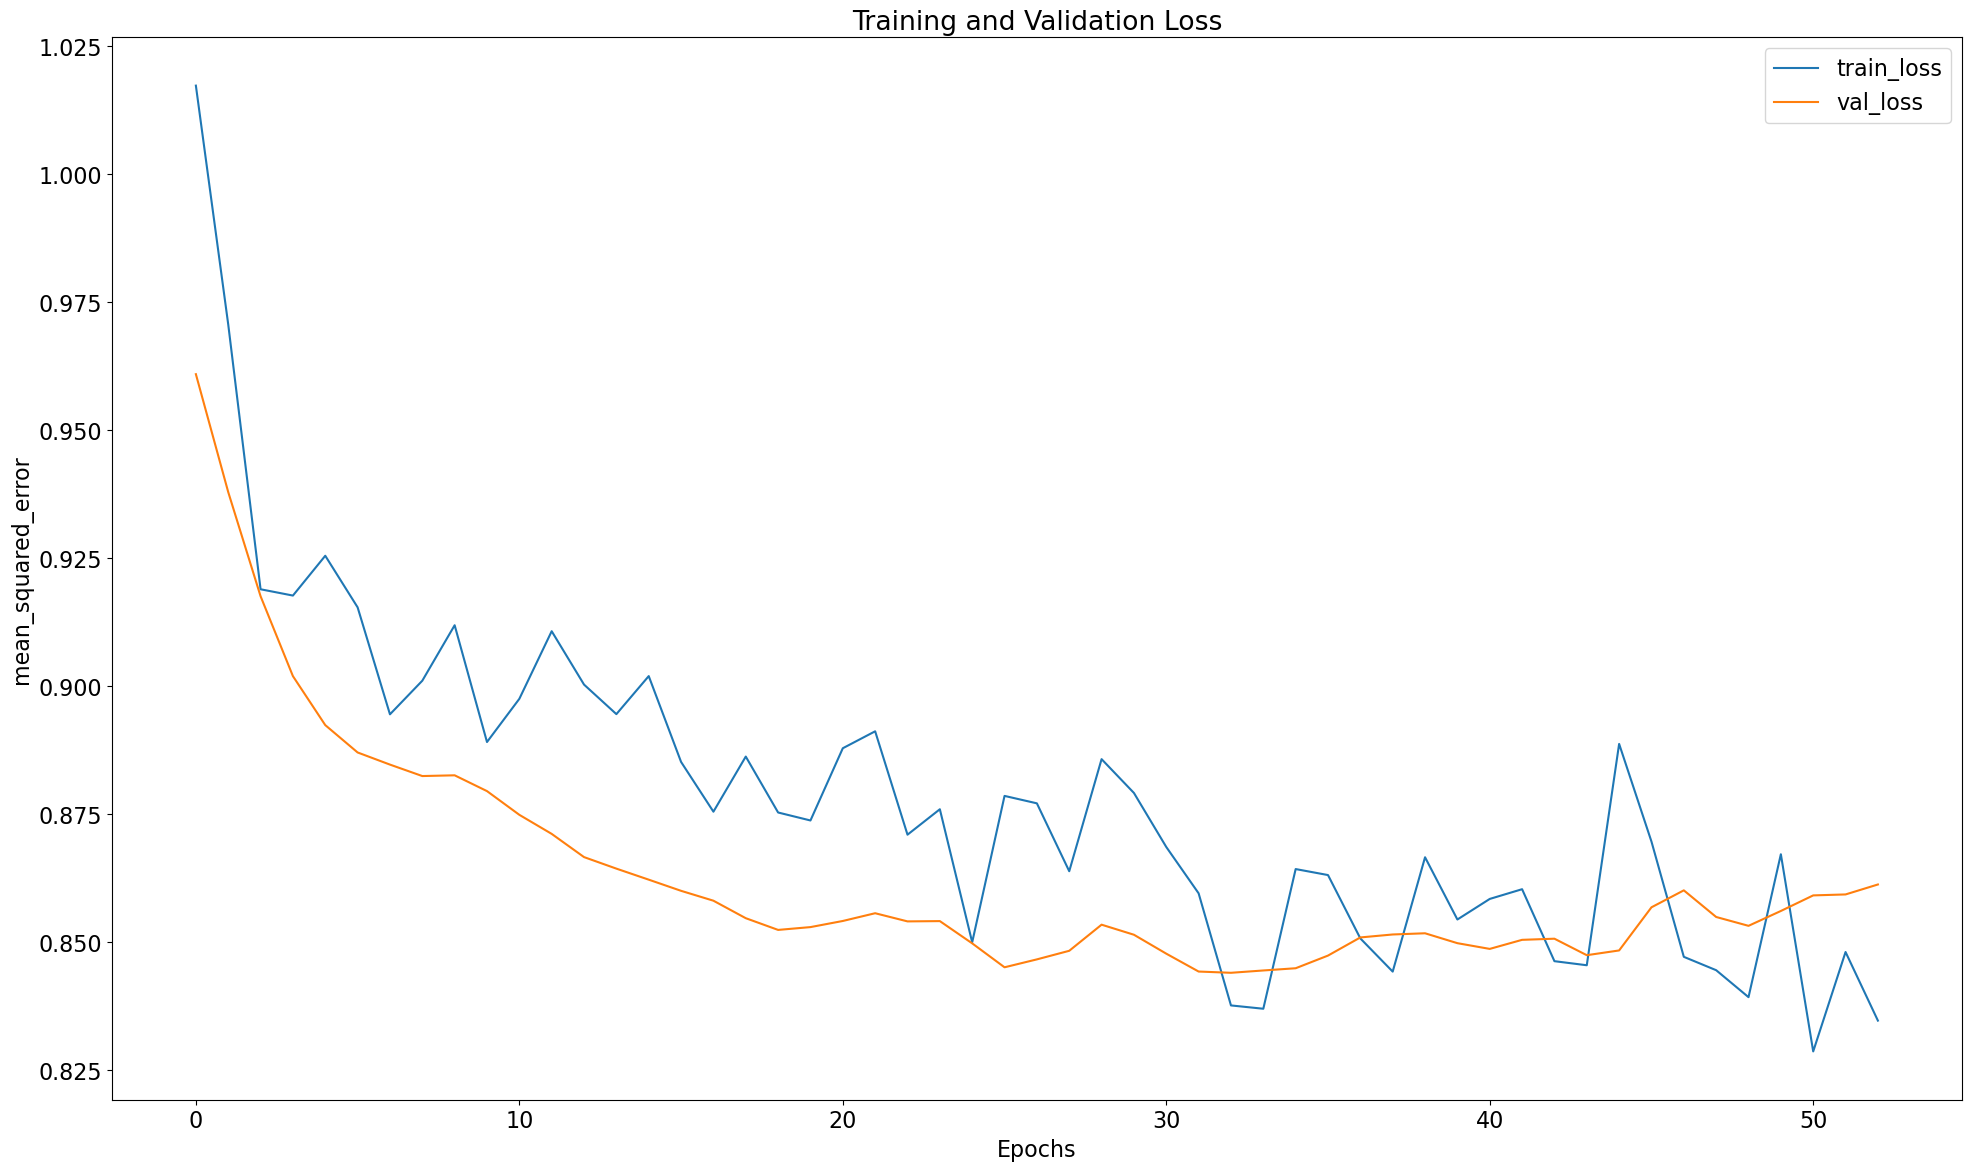

32/32 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [51]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

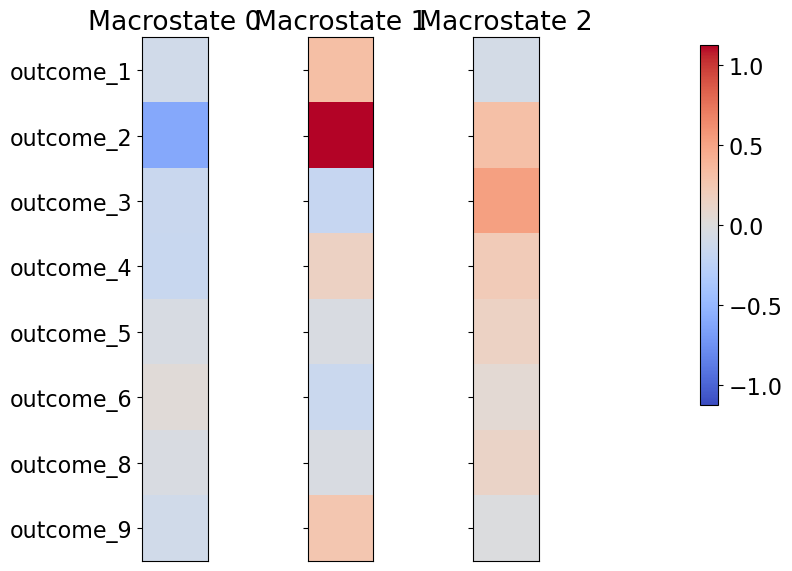

In [53]:
# visualize cause side macrostates
column = sim.drop(columns=['outcome_7','treatment_1', 'treatment_2', 'treatment_3', 'treatment_4', 'treatment_5', 'treatment_6', 'treatment_7', 'treatment_8', 'treatment_9']).columns
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0001', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?